<a href="https://colab.research.google.com/github/annabocharovaua/Time-Series-Analysis-Forecasting-and-Machine-Learning/blob/main/EWMA_VS_SES_Amadeus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd 
import numpy as np

In [5]:
df = pd.read_csv('airline_passengers.csv', index_col='Month', parse_dates=True, delimiter=';')

In [6]:
df.head()

,Passengers
Month,
2011-01-01,112058
2011-02-01,118120
2011-03-01,132040
2011-04-01,129022
2011-05-01,121042


In [7]:
df.isna().sum()

Passengers    0
dtype: int64

<Axes: xlabel='Month'>

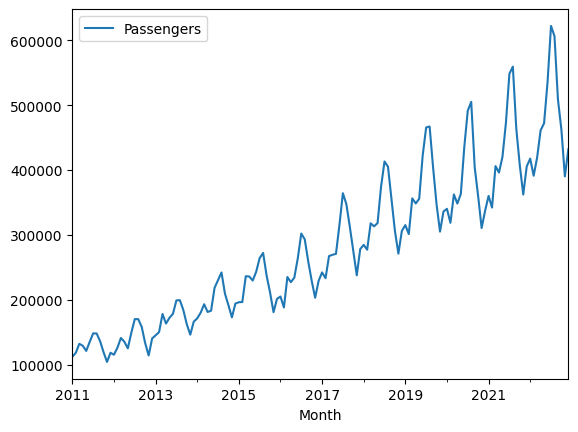

In [8]:
df.plot()

In [9]:
alpha = 0.2

In [10]:
df['EWMA'] = df['Passengers'].ewm(alpha=alpha, adjust=False).mean()

In [11]:
type(df['Passengers'].ewm(alpha=alpha, adjust=False))

pandas.core.window.ewm.ExponentialMovingWindow

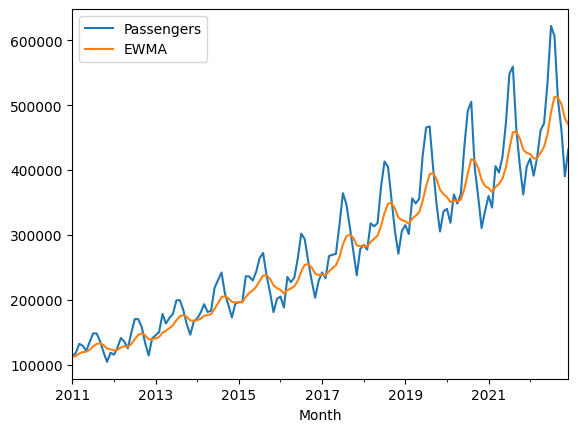

In [12]:
df.plot();

In [13]:
manual_ewma = []
for x in df['Passengers'].to_numpy():
  if len(manual_ewma) > 0:
    xhat = alpha * x + (1 - alpha) * manual_ewma[-1]
  else:
    xhat = x
  manual_ewma.append(xhat)
df['Manual'] = manual_ewma

<Axes: xlabel='Month'>

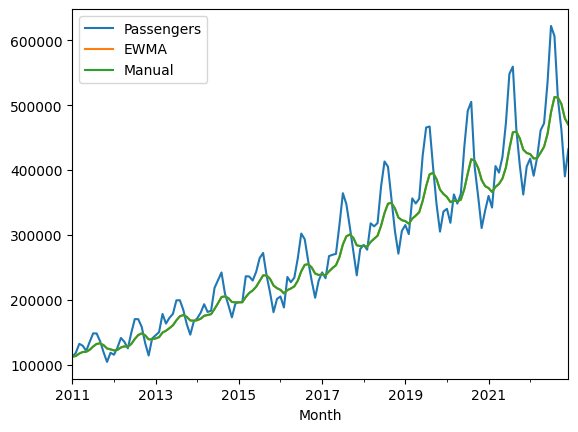

In [14]:
df.plot()

In [15]:
df.head()

,Passengers,EWMA,Manual
Month,,,
2011-01-01,112058,112058.0000,112058.0000
2011-02-01,118120,113270.4000,113270.4000
2011-03-01,132040,117024.3200,117024.3200
2011-04-01,129022,119423.8560,119423.8560
2011-05-01,121042,119747.4848,119747.4848


In [16]:
df.drop('Manual', axis=1, inplace=True) 

In [17]:
!pip install -U statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 62.9 MB/s eta 0:00:00
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.13.5
    Uninstalling statsmodels-0.13.5:
      Successfully uninstalled statsmodels-0.13.5


In [18]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [19]:
ses = SimpleExpSmoothing(df['Passengers'])

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [20]:
df.index


DatetimeIndex(['2011-01-01', '2011-02-01', '2011-03-01', '2011-04-01',
               '2011-05-01', '2011-06-01', '2011-07-01', '2011-08-01',
               '2011-09-01', '2011-10-01',
               ...
               '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01',
               '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01',
               '2022-11-01', '2022-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [21]:
df.index.freq = 'MS'

In [22]:
df.index

DatetimeIndex(['2011-01-01', '2011-02-01', '2011-03-01', '2011-04-01',
               '2011-05-01', '2011-06-01', '2011-07-01', '2011-08-01',
               '2011-09-01', '2011-10-01',
               ...
               '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01',
               '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01',
               '2022-11-01', '2022-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq='MS')

In [23]:
ses = SimpleExpSmoothing(
    df['Passengers'],
    initialization_method = 'legacy-heuristic'
)

In [24]:
res = ses.fit(smoothing_level = alpha, optimized = False)

In [25]:
res

In [26]:
res.predict(start=df.index[0], end=df.index[-1])

Month
2011-01-01    112058.000000
2011-02-01    112058.000000
2011-03-01    113270.400000
2011-04-01    117024.320000
2011-05-01    119423.856000
                  ...      
2022-08-01    488927.834426
2022-09-01    512427.467541
2022-10-01    511708.174032
2022-11-01    501756.939226
2022-12-01    479434.551381
Freq: MS, Length: 144, dtype: float64

In [27]:
df['SES'] = res.predict(start=df.index[0], end=df.index[-1])

In [28]:
np.allclose(df['SES'],res.fittedvalues)

True

<Axes: xlabel='Month'>

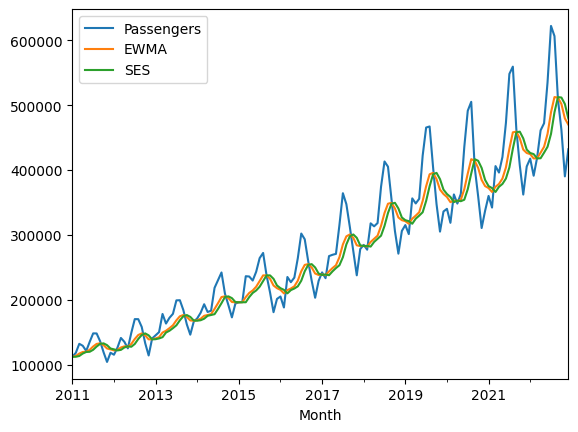

In [29]:
df.plot()

In [30]:
df.head()

,Passengers,EWMA,SES
Month,,,
2011-01-01,112058,112058.0000,112058.000
2011-02-01,118120,113270.4000,112058.000
2011-03-01,132040,117024.3200,113270.400
2011-04-01,129022,119423.8560,117024.320
2011-05-01,121042,119747.4848,119423.856


In [34]:
N_test = 12
train = df.iloc[:-N_test]
test = df.iloc[-N_test:]

In [35]:
ses = SimpleExpSmoothing(
    train['Passengers'],
    initialization_method = 'legacy-heuristic')
res = ses.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [36]:
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

<Axes: xlabel='Month'>

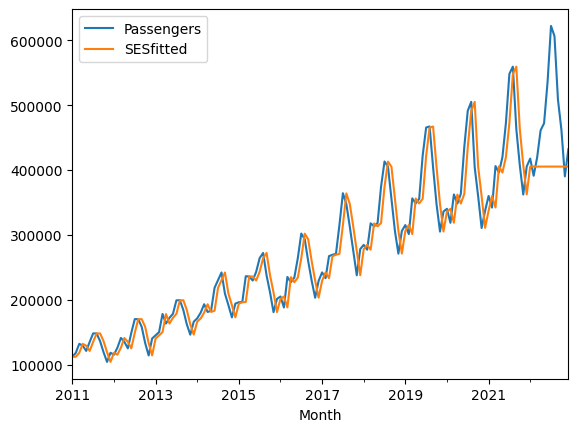

In [37]:
df.loc[train_idx, 'SESfitted'] = res.fittedvalues
df.loc[test_idx, 'SESfitted'] = res.forecast(N_test)
df[['Passengers', 'SESfitted']].plot()

In [38]:
res.params

{'smoothing_level': 0.995,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 112058.0,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

<ipython-input-46-d316d6996c72>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.loc[:, 'EWMA'] = ewma_train.values
<ipython-input-46-d316d6996c72>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'EWMA'] = ewma_test


<Axes: xlabel='Month'>

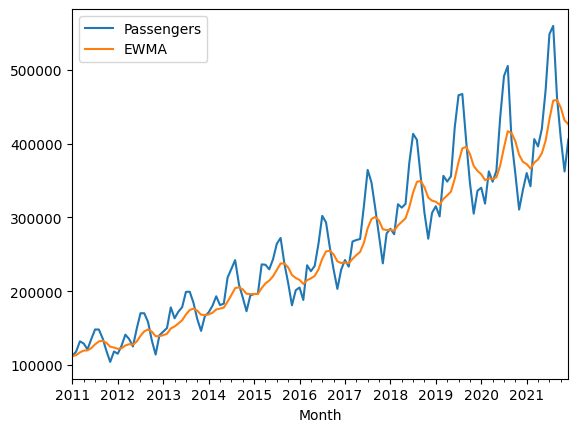

In [46]:
ewma_train = train['Passengers'].ewm(alpha=alpha, adjust=False).mean()
ewma_test = ewma_train.iloc[-1] * np.ones(N_test)

train.loc[:, 'EWMA'] = ewma_train.values
test.loc[:, 'EWMA'] = ewma_test

train[['Passengers', 'EWMA']].plot()

In [49]:
def root_mean_squared_error(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return rmse

In [54]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

ses_forecast = df.loc[test_idx, 'SESfitted']

ewma_forecast = df.loc[test_idx, 'EWMAfitted']

ses_rmse = root_mean_squared_error(test['Passengers'], ses_forecast)
ses_mse = mean_squared_error(test['Passengers'], ses_forecast)
ses_mae = mean_absolute_error(test['Passengers'], ses_forecast)
ses_r2 = r2_score(test['Passengers'], ses_forecast)

print("SES Metrics:")
print("RMSE:", ses_rmse)
print("MSE:", ses_mse)
print("MAE:", ses_mae)
print("R^2:", ses_r2)


SES Metrics:
RMSE: 103015.86003647944
MSE: 10612267419.055521
MAE: 76080.1871504375
R^2: -0.9149733067395827
